In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

In [7]:
mnist = fetch_openml('mnist_784', version=1)

In [8]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X,y = mnist['data'], mnist['target']

In [10]:
X.shape

(70000, 784)

In [17]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


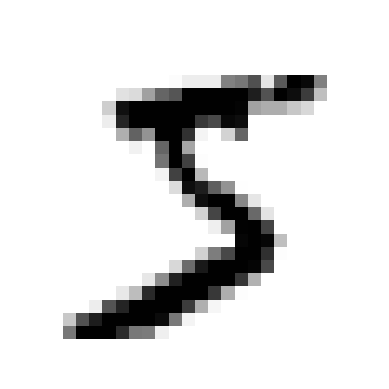

5


In [36]:
X = np.array(X)
some_digit = X[0]

y = y.astype(np.uint8)

some_digit_img = some_digit.reshape((28,28))

plt.imshow(some_digit_img, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

print(y[0])

In [37]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [39]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [41]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [43]:
sgd.predict([some_digit])

array([ True])

Implementing cross-validation

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for i_train, i_test in skfolds.split(X_train, y_train_5):
    clone_sgd = clone(sgd)
    
    X_train_folds = X_train[i_train]
    y_train_folds = y_train_5[i_train]
    X_test_fold = X_train[i_test]
    y_test_fold = y_train_5[i_test]

    clone_sgd.fit(X_train_folds, y_train_folds)

    y_pred = clone_sgd.predict(X_test_fold)

    n_correct = sum(y_pred == y_test_fold)

    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [59]:
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [61]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [62]:
never_5 = Never5Classifier()
cross_val_score(never_5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [68]:
np.zeros((len(X_train[:20]), 1), dtype=bool)

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])